In [105]:
"""
- Define domain for the problem: \Omega \in (0, 1)
- Define domain discretization degree n. n := number of interior points | full interval is
    a = x_{0} < x_{i} < x_{n+1} = b, therefore:
        - n+2 := number of total points
        - n+1 := number of intervals
        - n+1 := number of hat functions, given that elements at {x_{0}, x_{n+1}} are half complete
        - step := (b-a) / (n+1)
"""
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from enum import Enum
from typing import Tuple, List

from element import *
from basis import *
from source import *
from bilinear_form import *
from util import *
from interpolator import *
from util import L2ErrorComputer

In [106]:
def plot_result(x, u, X, U, interpolator, title='Title'):
    # x: node vector
    # u: solution vector
    # X: positions (vector), where the analytic solution has been evaluated
    # U: function values (vector) of the analytic solution
    u_int = np.zeros(X.size)
    for idx, val  in enumerate(X[:-1]):
        u_int[idx] = interpolator(val)
    u_nod = np.zeros(x.size)
    for idx, val  in enumerate(x[:-1]):
        u_nod[idx] = interpolator(val)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(X,u_int, '-.r', label = 'interpolated result')
    ax.plot(x,u_nod, 'xr', label = 'node values')
    ax.plot(X, U, ':', label = 'analytic solution')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
    ax.set_title(title)
    ax.legend()
    plt.show()

def plot_error(x, u, title='L2-error ||u-u_h||_{L^2}'):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.loglog(x,u, 'xr--')
    ax.set_xlabel('max gridsize')
    ax.set_ylabel('error')
    ax.set_title(title)
    ax.invert_xaxis()
    plt.show()

def propagate_solutions(u: np.ndarray, els: List[Element]):
    for idx, el in enumerate(els):
        size = len(el.get_coords())
        begin = idx * (size - 1)
        el.set_solutions(tuple(u[begin: begin +  size]))

def solve_approx(omega:Tuple[int, int], 
                 n_els: int = 25, # number of elements
                 el_type: ElementType = ElementType.LIN, 
                 prob_type: ProblemType = ProblemType.CONST):
    a, b = omega
    disc_domain, elements = ElementFactory.get_elements_for_domain(omega, n_els, el_type)
    basis = BasisFactory.get_basis_for_domain(disc_domain, el_type)
    
    if prob_type == ProblemType.CONST:
        source = ConstantSource(1)
    elif prob_type == ProblemType.DIRAQ:
        source = DiracDelta(0.5, 2)
    
    stiffness_matrix = StiffnessMatrix(basis)
    rhs = RHS(source, basis)
    u = np.concatenate((np.concatenate(([0], np.linalg.solve(stiffness_matrix.get(), rhs.get()), [0]), axis=None)), axis=None)
    return disc_domain, elements, u

def solve_exact(x, prob_type: ProblemType):
    if prob_type == ProblemType.DIRAQ:
        return x if x <= 0.5 else -(x-1)
    elif prob_type == ProblemType.CONST:
        return -0.5 * (x - 0.5)**2 + 1 / 8

def get_all_errors(
    omega: Tuple[float, float] = (0, 1), 
    prob_types: List[ProblemType] = [prob_type for prob_type in ProblemType],
    el_types: List[ElementType] = [el_type for el_type in ElementType],
    n_els_range: List[int] = [i for i in range(10, 1001, 51)]
):
    err = {}
    for prob_type in prob_types:
        _sol_exact = lambda x: solve_exact(x, prob_type)
        err[prob_type.name] = {}

        for el_type in el_types:
            err[prob_type.name][el_type.name] = {}
            err[prob_type.name][el_type.name]['error'] = []
            err[prob_type.name][el_type.name]['size'] = []

            for n_els in n_els_range:
                x, els, u = solve_approx(omega=omega, n_els=n_els, el_type=el_type, prob_type=prob_type)
                propagate_solutions(u, els)

                _err = L2ErrorComputer(_sol_exact, Interpolator(els).intepolate).eval(omega)
                err[prob_type.name][el_type.name]['error'].append(_err)
                err[prob_type.name][el_type.name]['size'].append(x[1] - x[0])
    return err

In [107]:
prob_type = ProblemType.CONST
X = np.linspace(0, 1, 1000)
U = [solve_exact(x, prob_type=prob_type) for x in X]

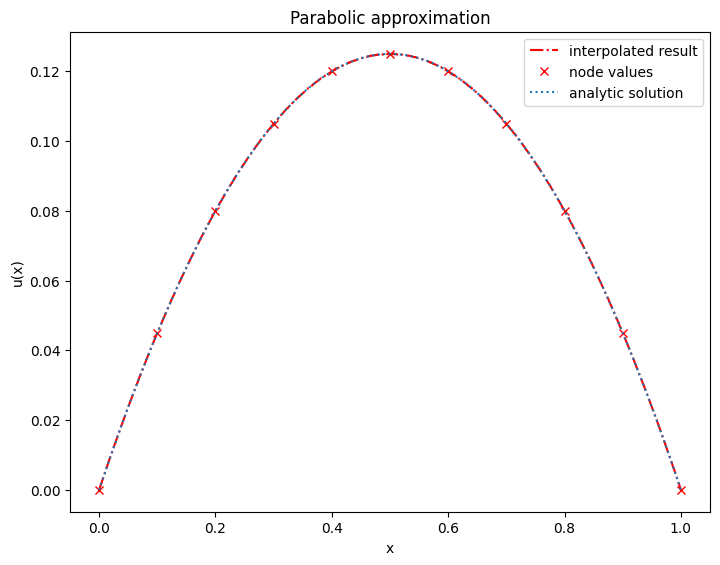

In [108]:
n_els_quad = 5
x_quad, el_quad, u_quad = solve_approx(omega=(0, 1), n_els=n_els_quad, el_type=ElementType.QUAD, prob_type=prob_type)
propagate_solutions(u_quad, el_quad)
interp_quad = Interpolator(el_quad)

plot_result(x_quad, u_quad, X, U, interp_quad.intepolate, "Parabolic approximation")

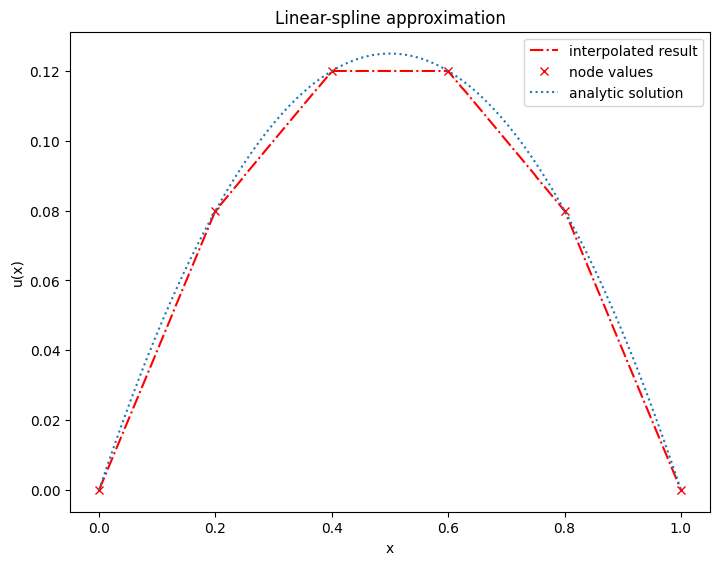

In [109]:
n_els_lin = 5
x_lin, el_lin, u_lin = solve_approx(omega=(0, 1), n_els=n_els_lin, prob_type=prob_type)
propagate_solutions(u_lin, el_lin)
interp_lin = Interpolator(el_lin)

plot_result(x_lin, u_lin, X, U, interp_lin.intepolate, "Linear-spline approximation")

In [103]:
n_els_range = [i for i in range(3, 105, 3)]
err = get_all_errors(
    omega=(0, 1), 
    el_types=[ElementType.QUAD],
    prob_types=[ProblemType.CONST],
    n_els_range=n_els_range
)

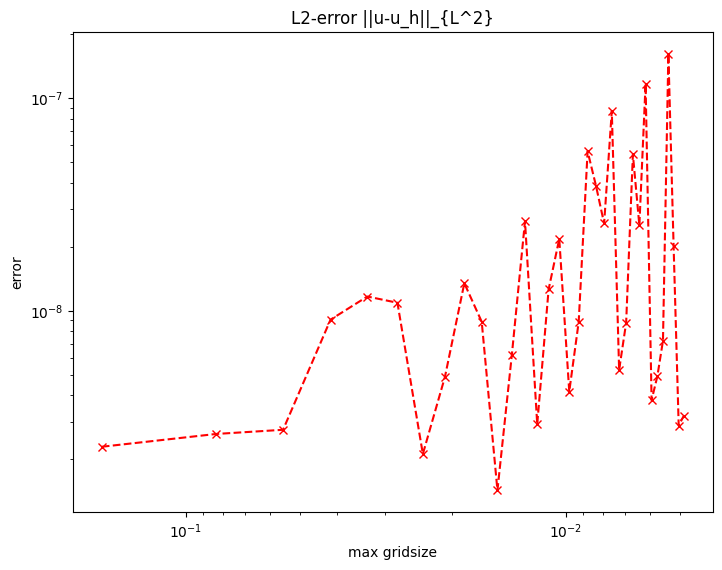

In [104]:
setting = (
    ProblemType.CONST.name,
    ElementType.QUAD.name
)

plot_error(
    err[setting[0]][setting[1]]['size'], 
    err[setting[0]][setting[1]]['error']
)